In [144]:
import pandas as pd
import AnalFunctions as af
import numpy as np
import matplotlib.pyplot as plt
import os

path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var, test_var2, test_str2, lin_var, T_test_list, sec_test_var, N_ped, fps, mot_frac = af.var_ini()
af.file_writer(path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var)

sl = "/"
T_test_list = lin_var[test_var2]
lattice_type = 'jule'
runs_tested = N_runs
traj_testvar2 = []


def dist(x1, y1, x2, y2, x3, y3): # x3,y3 is the point

    px = x2-x1
    py = y2-y1

    norm = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)

    #u_new = np.array([1 if ui > 1 else 0 for ui in u])
    u[u > 1] = 1
    u[u < 0] = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    # Note: If the actual distance does not matter,
    # if you only want to compare what this function
    # returns to other results of this function, you
    # can just return the squared distance instead
    # (i.e. remove the sqrt) to gain a little performance

    dist = np.sqrt(dx*dx + dy*dy)
    return dist



FileNotFoundError: [Errno 2] File b'path.csv' does not exist: b'path.csv'

In [145]:
waittime_list = []
test_var_list = []
test_var2_list = []
b_list = []
N_ped_list = []
T_list = []
os.system("mkdir " + path + "waittime")
t_min = 10
t_max = 30
t_start = t_min * fps
t_end = t_max * fps


In [70]:
from multiprocessing import Pool


<calculating b = 0.8>


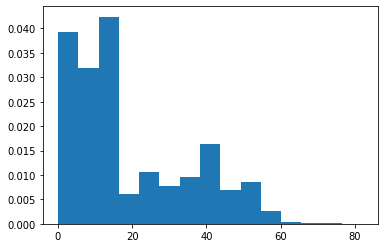

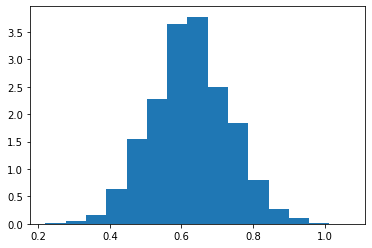

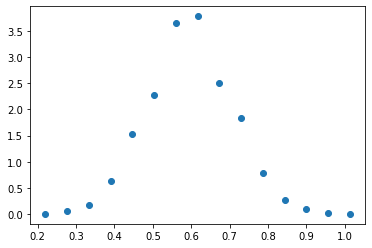

0.6230380961653476
18.64258551656546
<calculating b = 0.9>


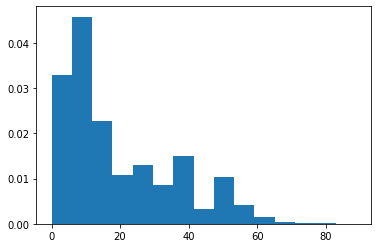

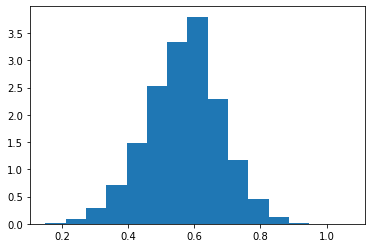

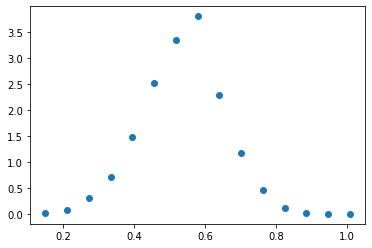

0.5676843857918106
19.303777589288483
<calculating b = 1.0>


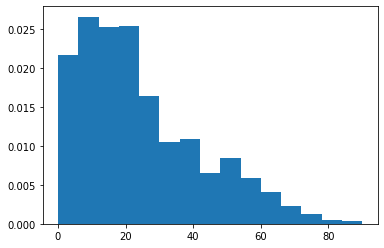

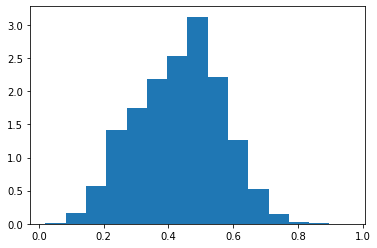

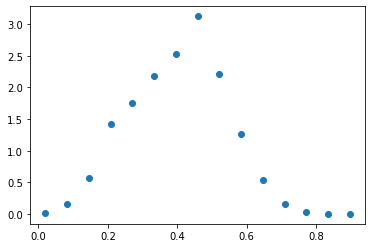

0.4327436676798378
24.32208238078256
<calculating b = 1.1>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


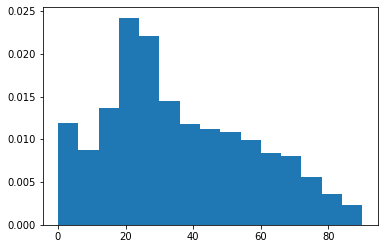

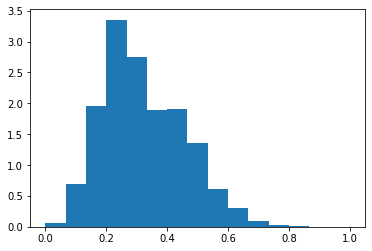

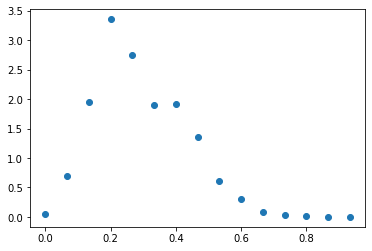

0.3199812757830975
35.69579272298227
<calculating b = 1.2>


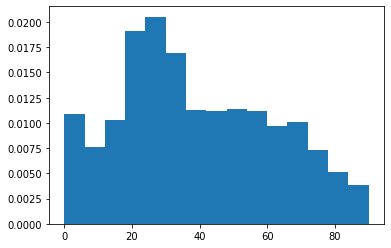

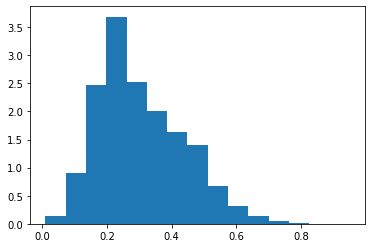

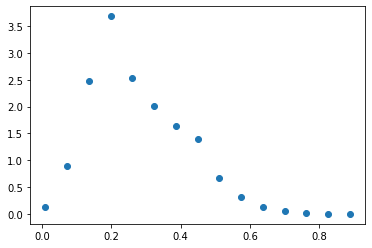

0.3046030420868394
39.221662225610956
<calculating b = 1.3>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


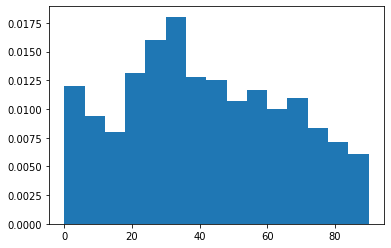

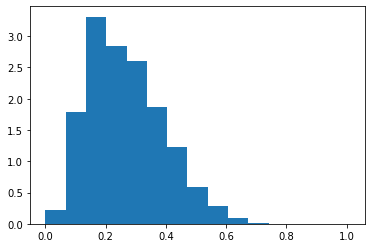

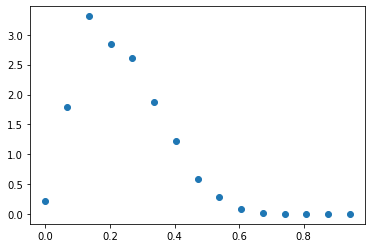

0.26692279141202446
41.59874337002301
<calculating b = 1.4>


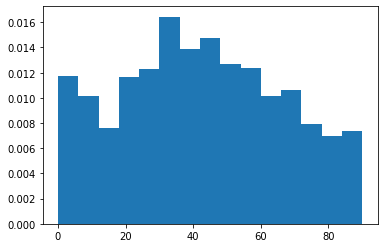

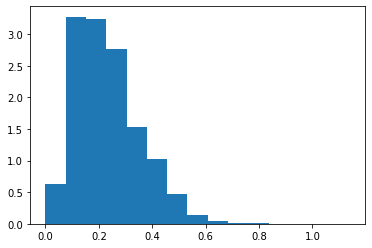

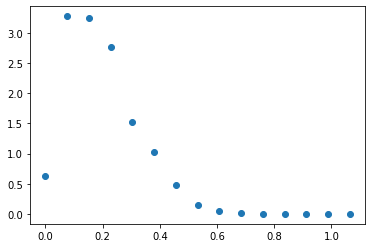

0.232755685238158
42.61208226077983
<calculating b = 1.5>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


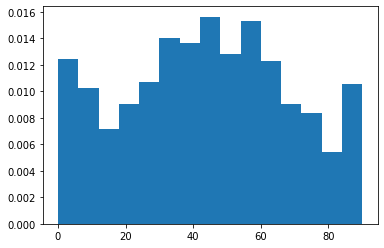

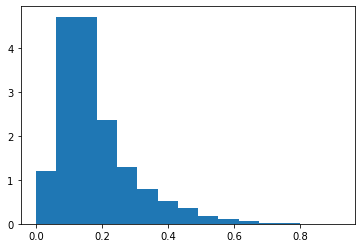

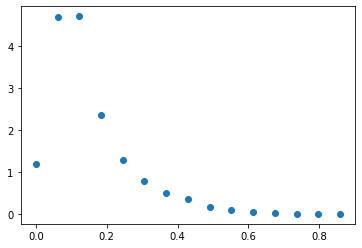

0.17934302286127163
43.996976784775256
<calculating b = 1.6>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


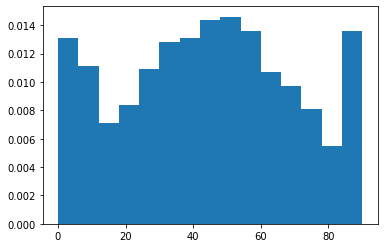

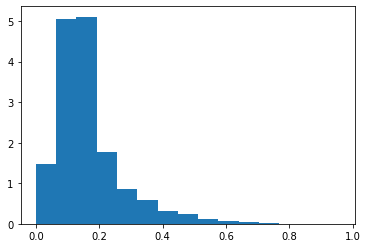

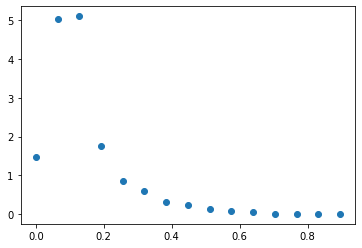

0.16494154371603592
44.456230472895626
<calculating b = 1.7>


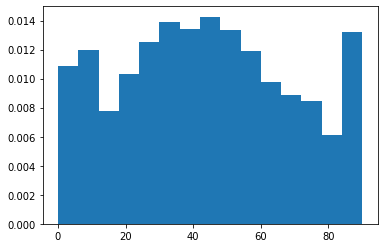

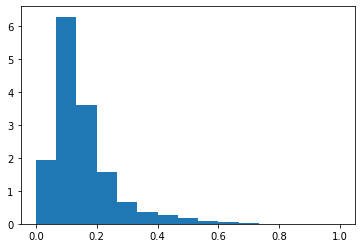

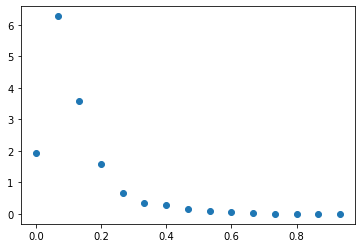

0.15192811473778486
43.857440339425516
<calculating b = 1.8>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


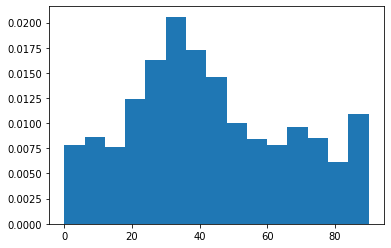

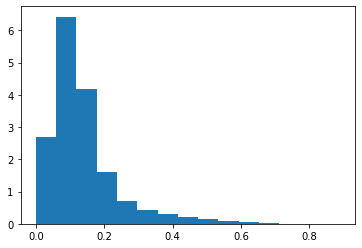

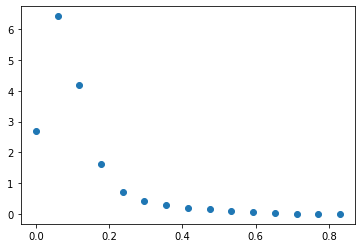

0.13417546075797704
43.044915943649215
<calculating b = 1.9>


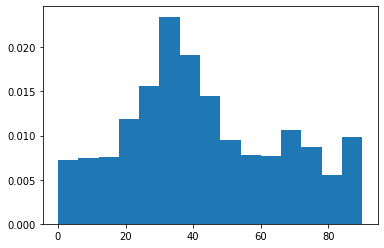

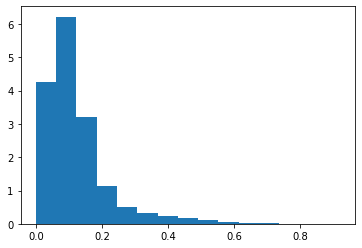

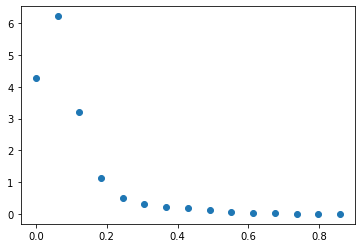

0.12541882665638662
43.04271818869838
<calculating b = 2.0>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


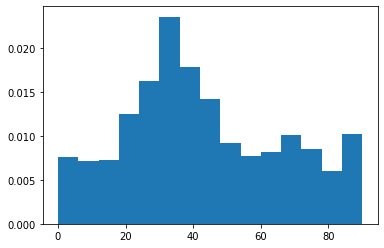

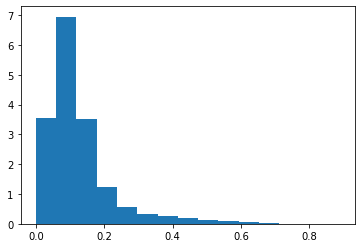

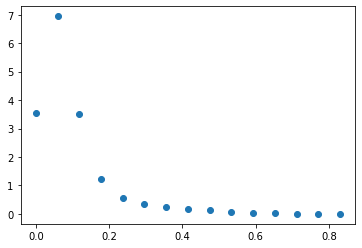

0.12151860383417466
43.05842247688467
<calculating b = 2.1>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


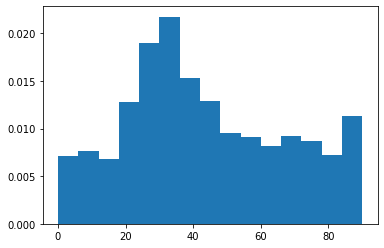

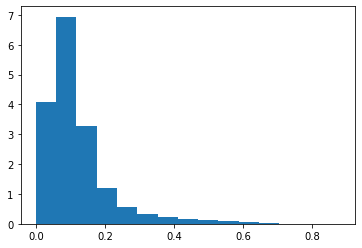

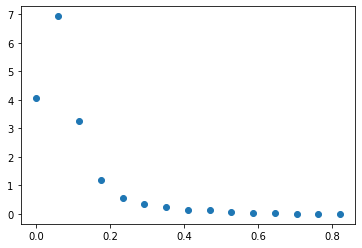

0.11647862433760103
43.55825284441664
<calculating b = 2.2>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


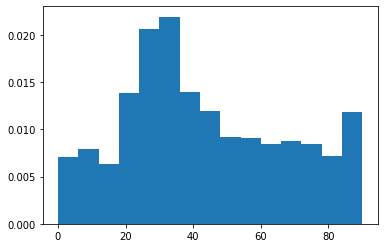

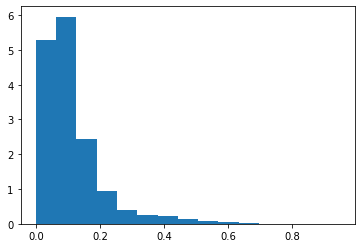

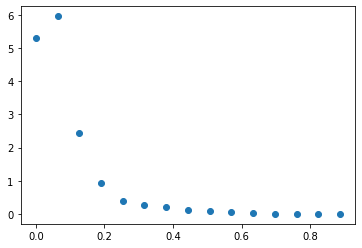

0.1132031631164026
43.323834343526734
<calculating b = 2.3>


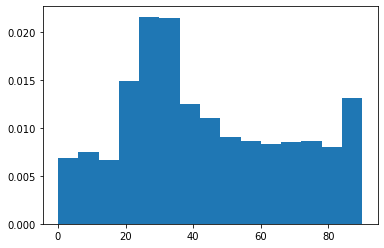

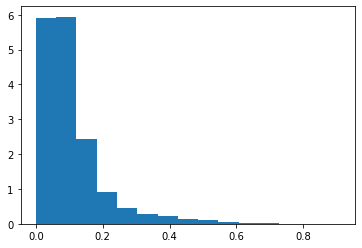

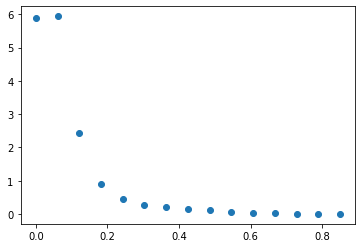

0.11129968902402052
43.747336998904544
<calculating b = 2.4>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


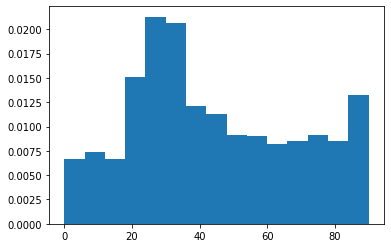

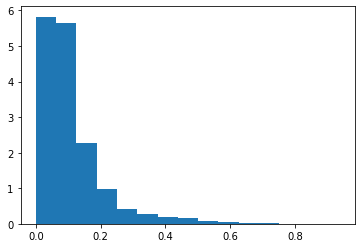

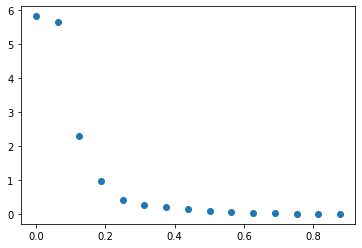

0.11138960358982126
44.10801254338335
<calculating b = 2.5>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


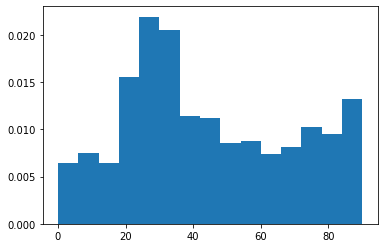

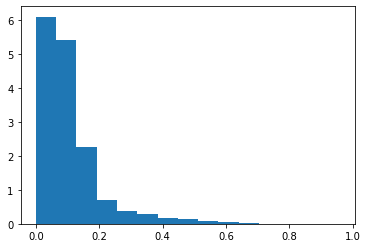

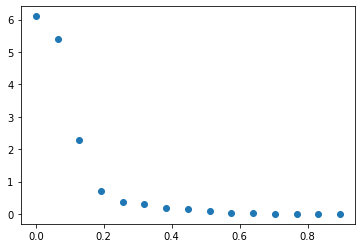

0.10797834032199617
44.34217916977942
<calculating b = 2.6>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


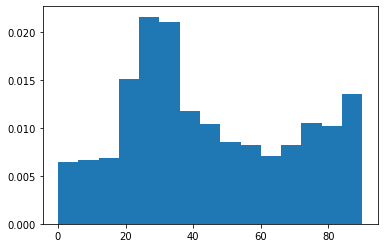

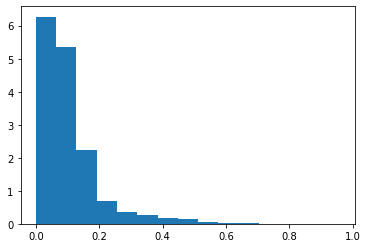

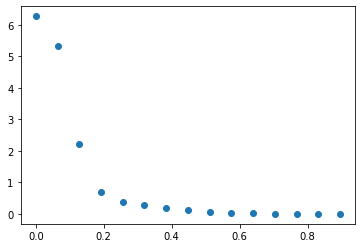

0.10554395089858219
44.659821107958294
<calculating b = 2.7>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


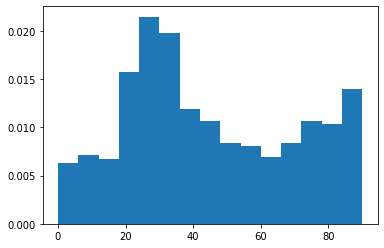

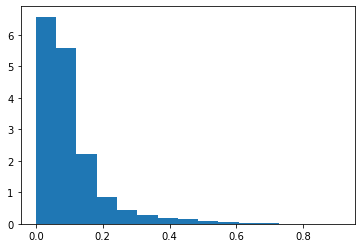

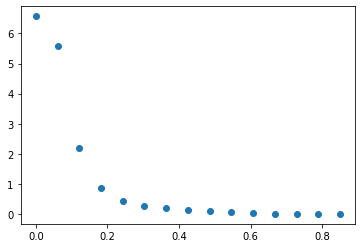

0.10629872101980523
44.78843697505524
<calculating b = 2.8>


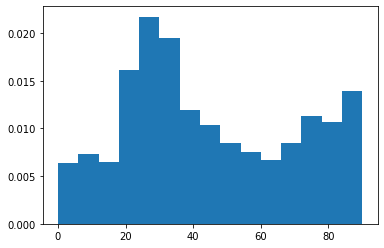

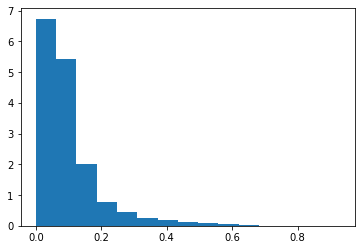

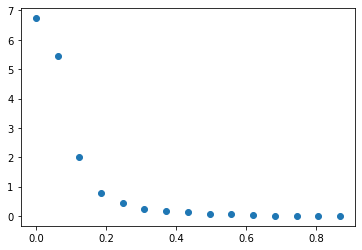

0.10320625724445878
44.866452661341846
<calculating b = 2.9>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


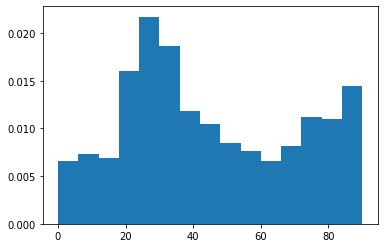

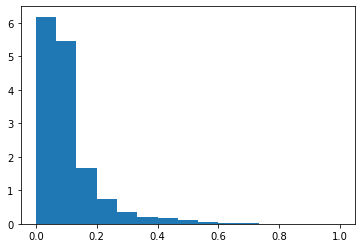

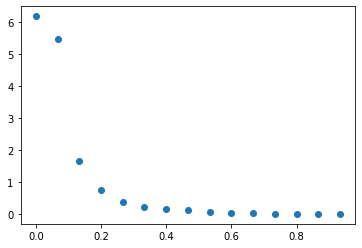

0.10447580861039088
nan
<calculating b = 3.0>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


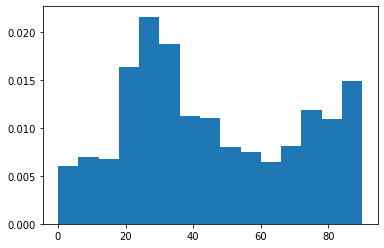

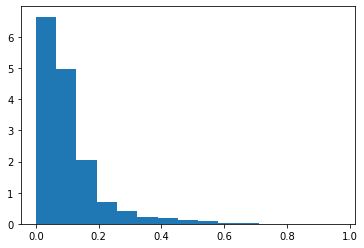

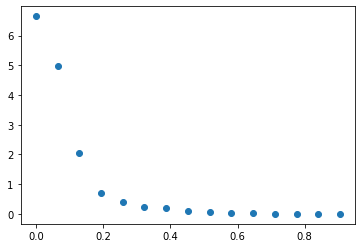

0.10318619832141747
45.30555436612994
<calculating b = 3.1>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


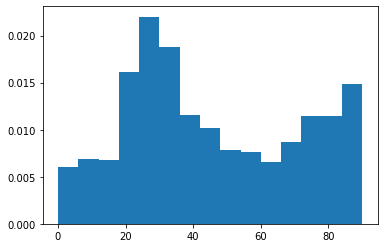

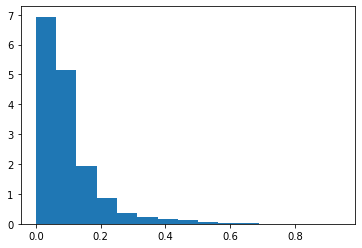

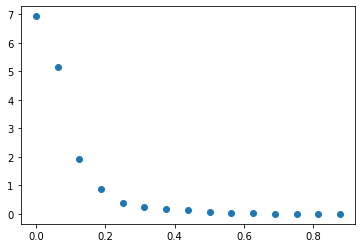

0.10174406766328675
nan
<calculating b = 3.2>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


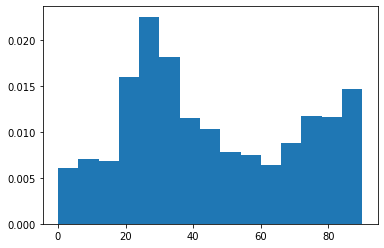

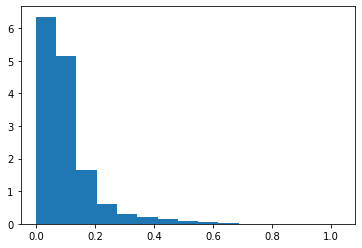

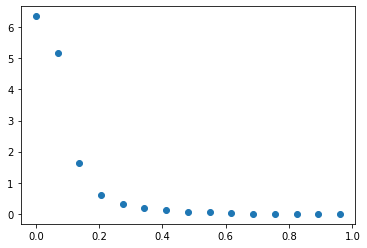

0.10085430308209059
45.3911508384165
<calculating b = 3.3>


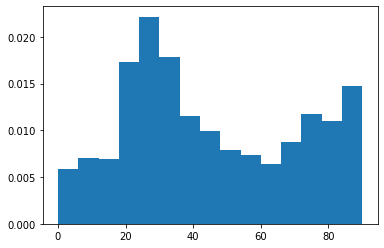

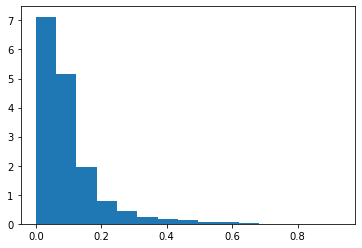

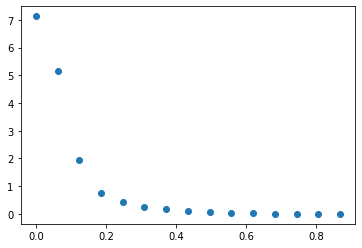

0.10041071940328941
45.19072215757342
<calculating b = 3.4>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


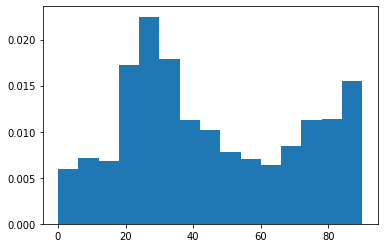

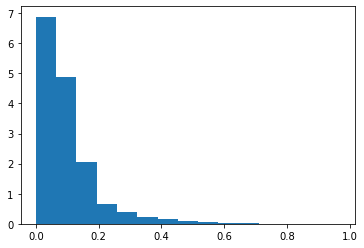

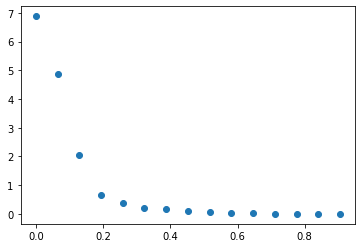

0.10063816190237722
45.289015996942524
<calculating b = 3.5>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


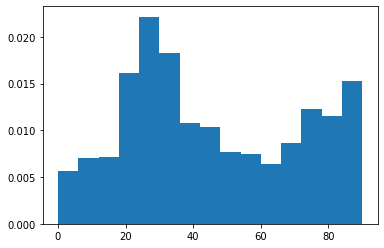

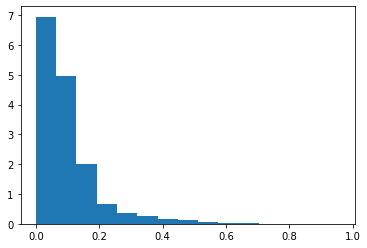

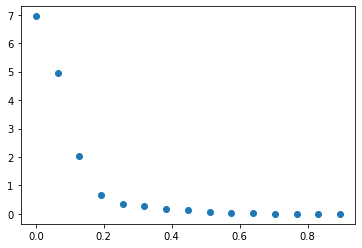

0.10086891869738378
45.70536975030431
<calculating b = 3.6>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


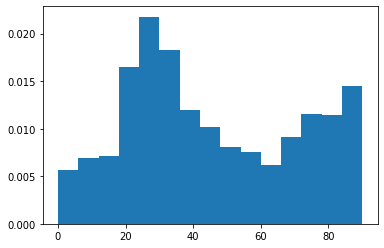

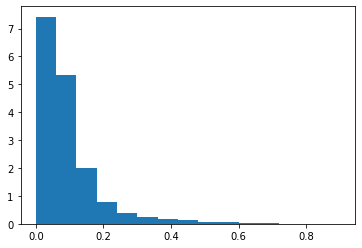

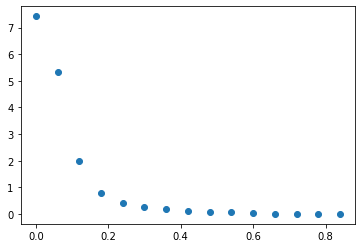

0.09957752294263593
45.38125318237008
<calculating b = 3.7>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


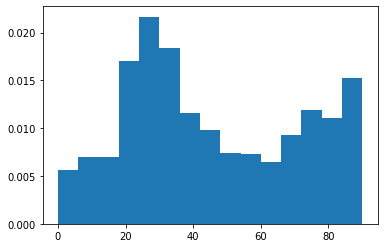

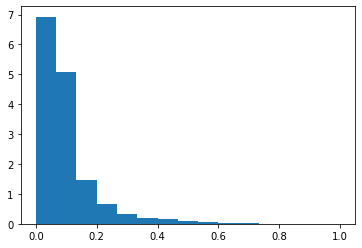

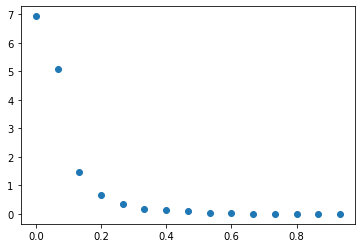

0.09778210609719425
45.53434642502075
<calculating b = 3.8>


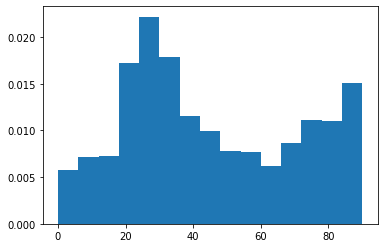

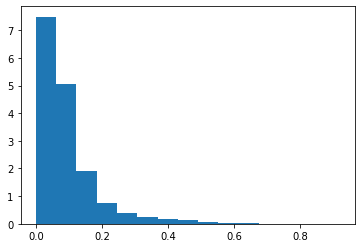

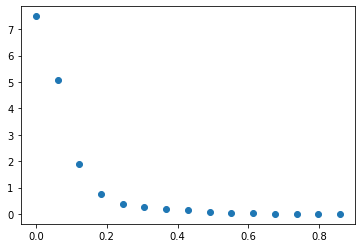

0.09841857722765171
45.0974804566425
<calculating b = 3.9>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


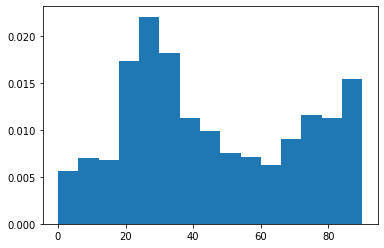

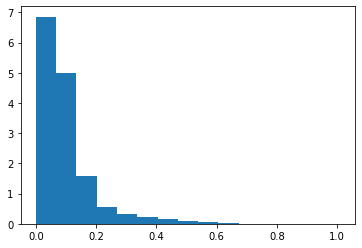

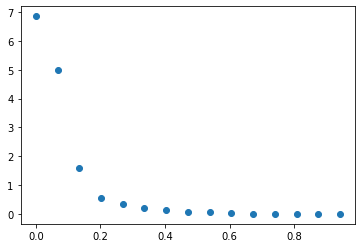

0.09847114622094796
45.4812787461773
<calculating b = 4.0>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


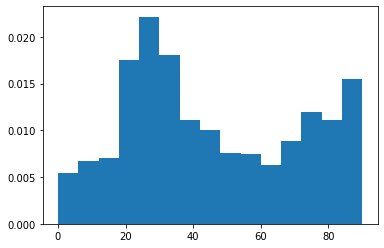

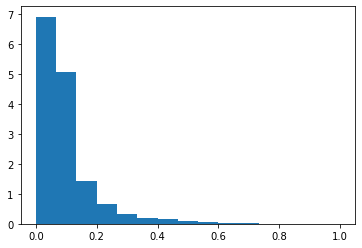

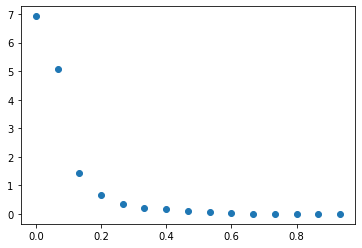

0.09859393617660225
45.578492949728705
<calculating b = 4.1>


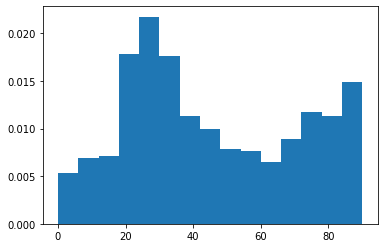

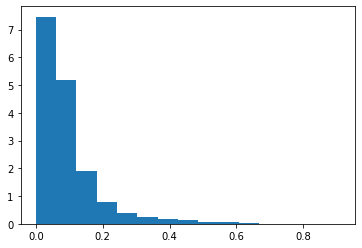

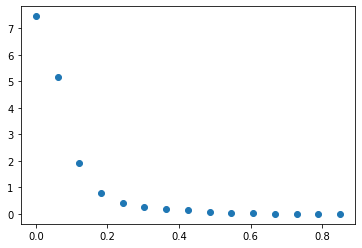

0.09915740314283261
45.493749227312904
<calculating b = 4.2>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


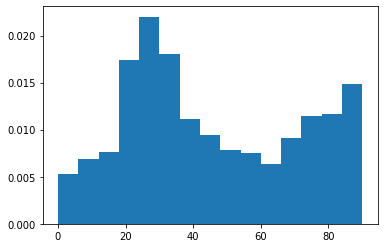

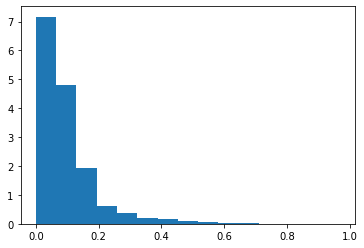

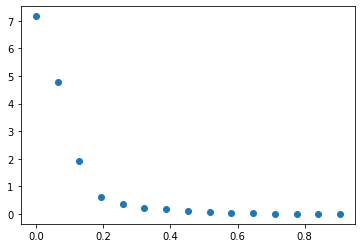

0.09760654169461508
45.39878403297757
<calculating b = 4.3>


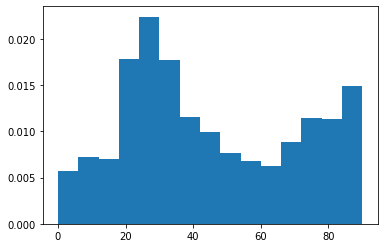

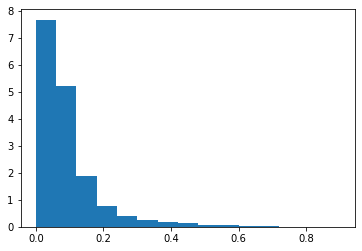

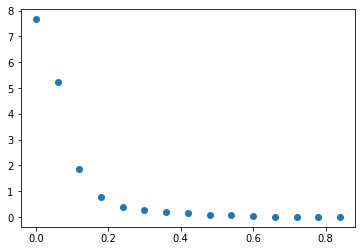

0.09838888523613748
45.0774568513798
<calculating b = 4.4>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


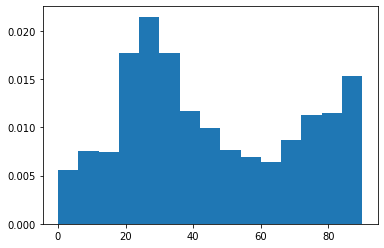

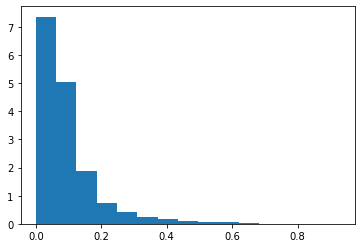

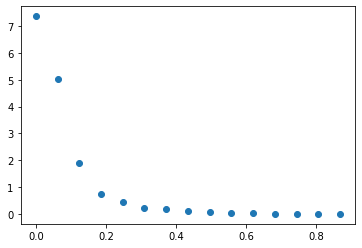

0.09874021397492466
nan
<calculating b = 4.5>


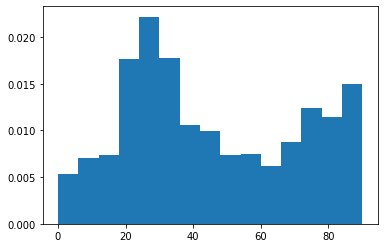

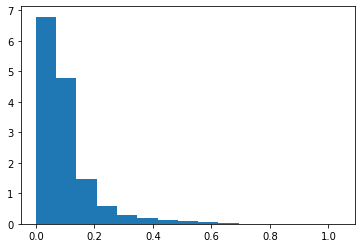

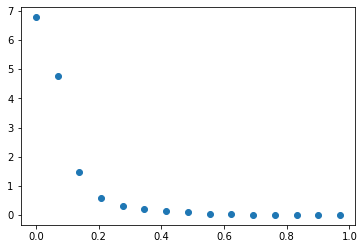

0.09757814636189631
45.4877122644399
<calculating b = 4.6>


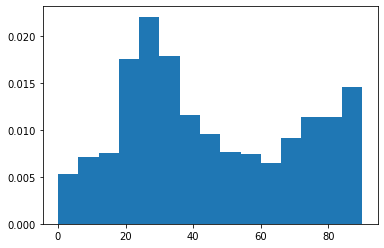

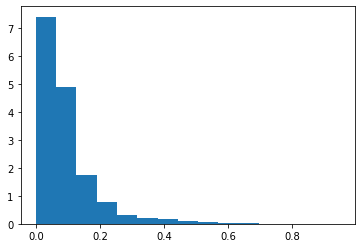

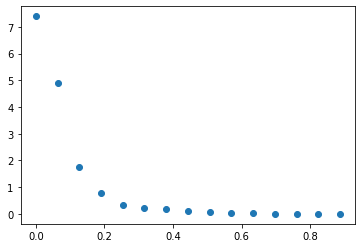

0.09698653108927632
45.20330323784202
<calculating b = 4.7>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


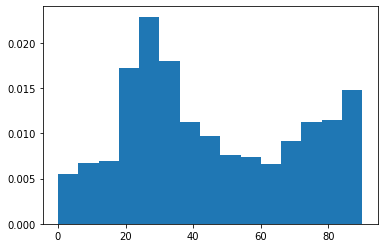

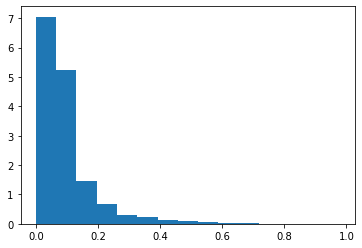

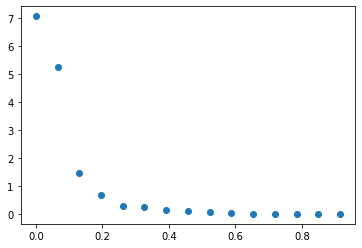

0.09750615776469804
45.37419546918907
<calculating b = 4.8>


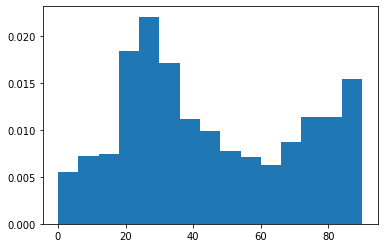

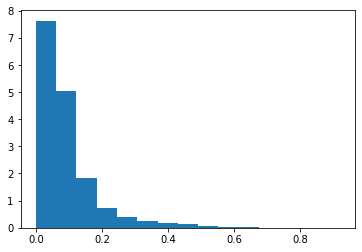

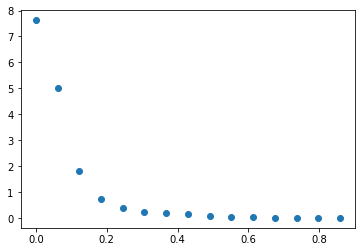

0.09726433043431189
45.20824374000439
<calculating b = 4.9>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


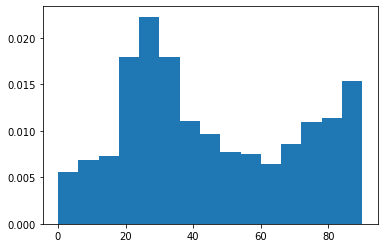

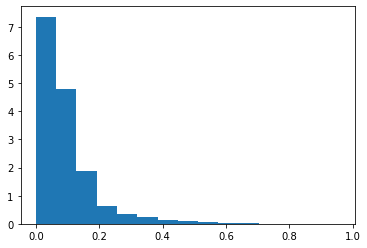

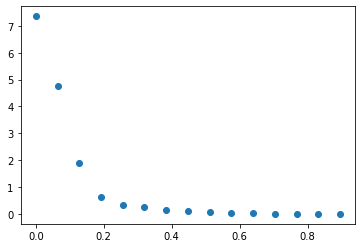

0.09704762334978374
45.20607825798778
<calculating b = 5.0>


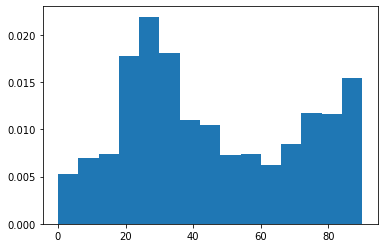

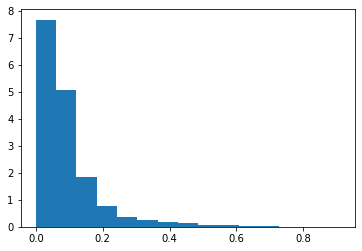

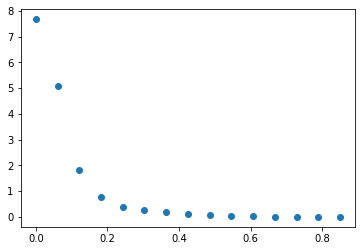

0.09799400521939396
45.46294573305657
<calculating b = 5.1>


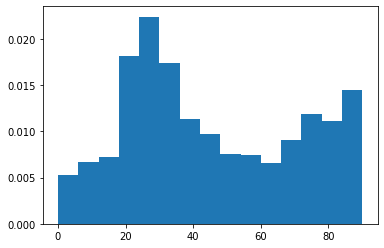

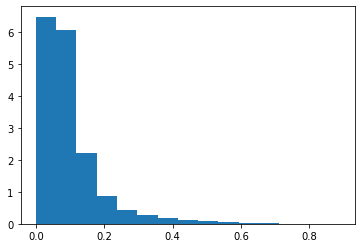

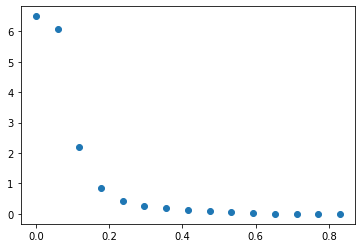

0.09660267632864955
45.29847221279651
<calculating b = 5.2>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


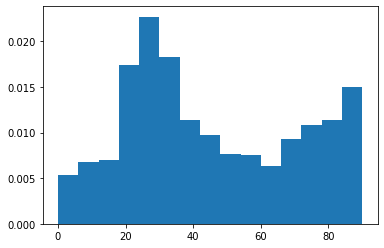

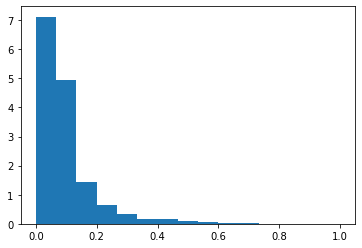

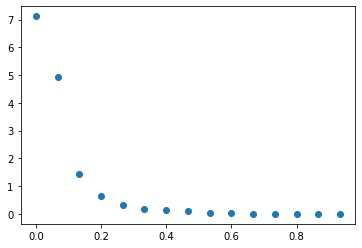

0.0965766333981933
nan
<calculating b = 5.3>


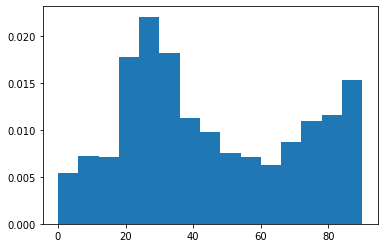

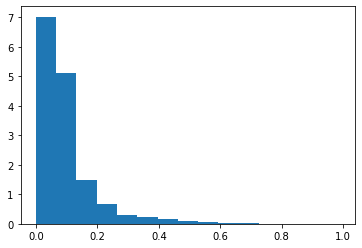

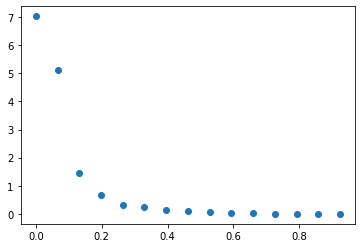

0.0977997220889006
45.22430894563526
<calculating b = 5.4>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


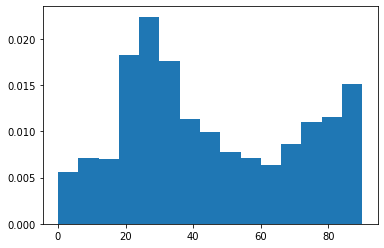

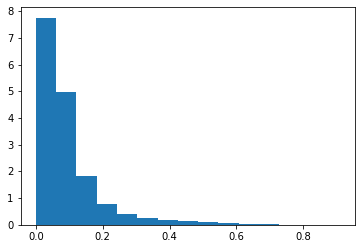

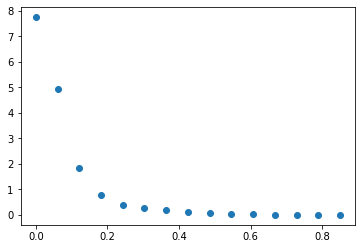

0.09793510257559176
45.12598346491571
<calculating b = 5.5>


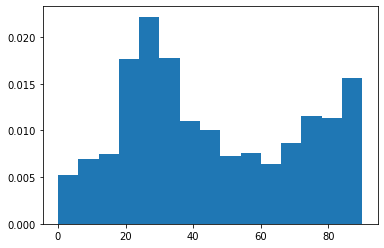

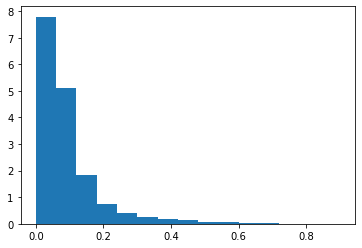

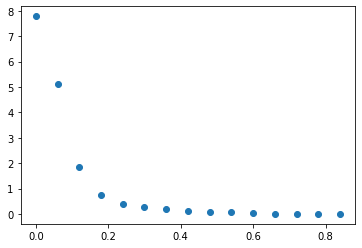

0.09800339188796232
45.4841928497208
<calculating b = 5.6>


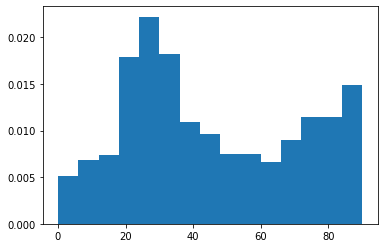

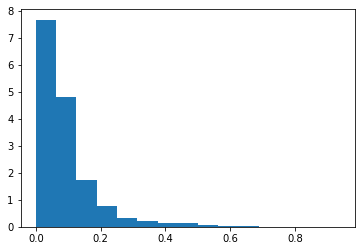

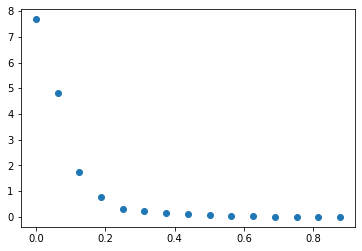

0.09523597073745507
45.38919132869564
<calculating b = 5.7>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


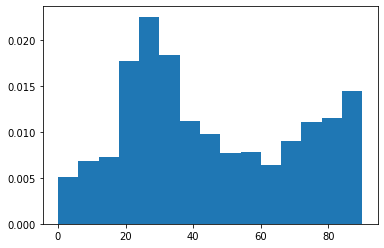

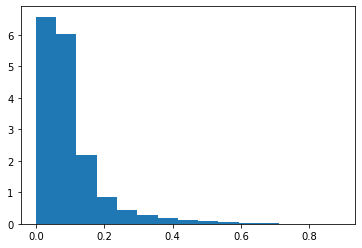

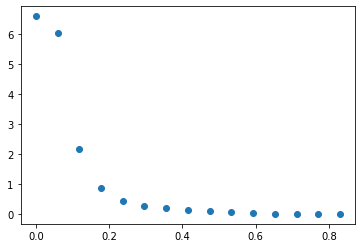

0.09635880358870975
45.22393521582373
<calculating b = 5.8>


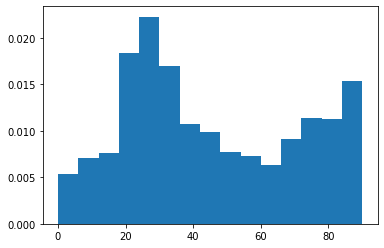

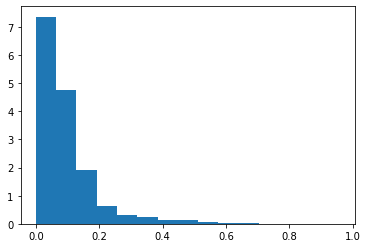

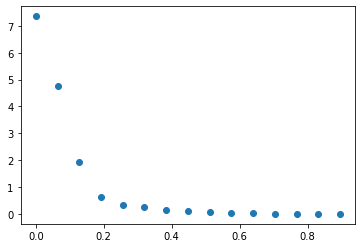

0.09682982130621236
45.30561364489245
<calculating b = 5.9>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


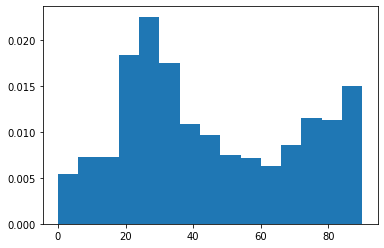

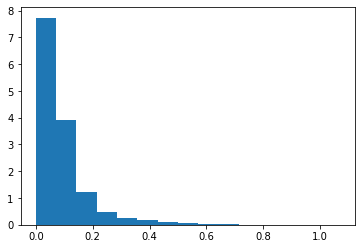

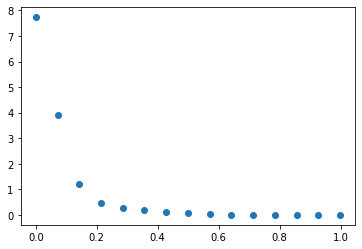

0.09602385017109218
nan
<calculating b = 6.0>


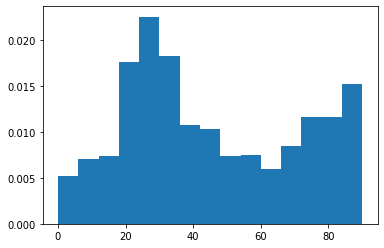

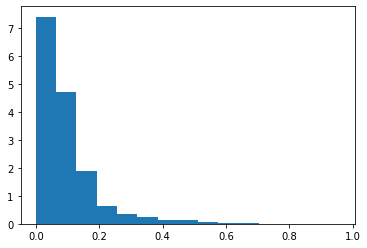

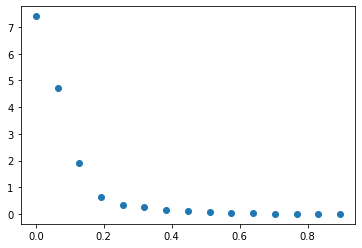

0.09734153619593863
45.343835946455734
<calculating b = 6.1>


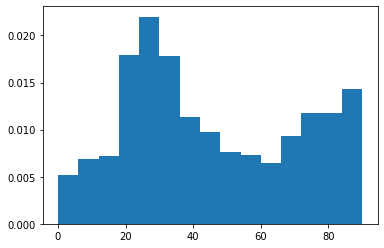

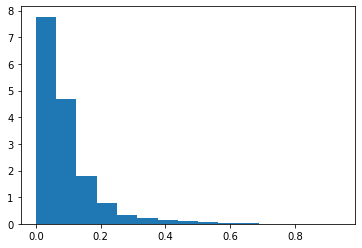

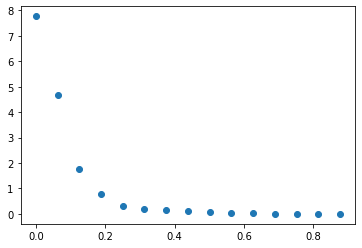

0.09462399585191482
45.4207501406949
<calculating b = 6.2>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


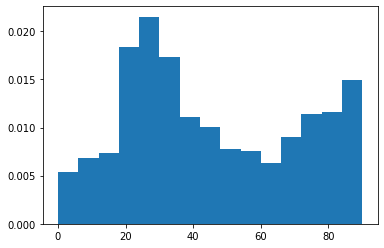

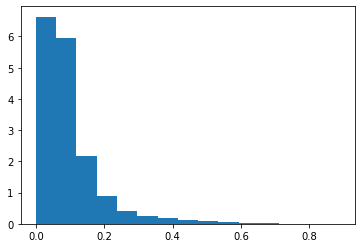

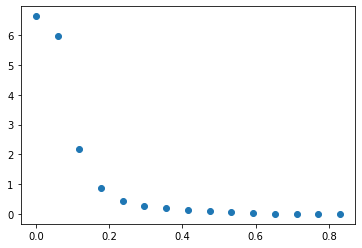

0.09624800370923704
45.421755269060746
<calculating b = 6.3>


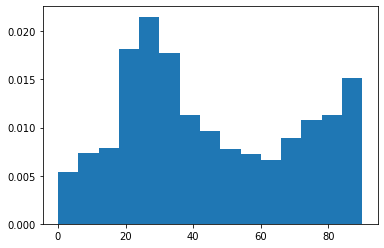

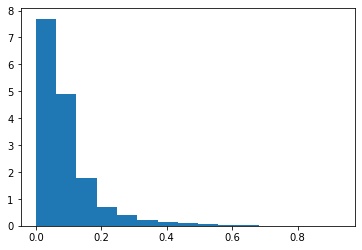

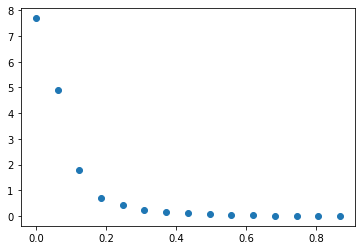

0.0958969723579719
45.102221400083806
<calculating b = 6.4>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


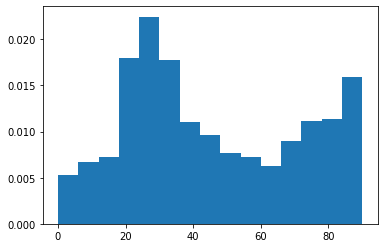

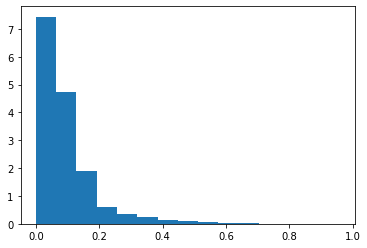

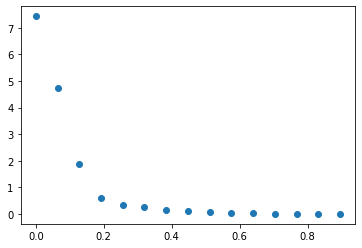

0.09638859572529516
nan
<calculating b = 6.5>


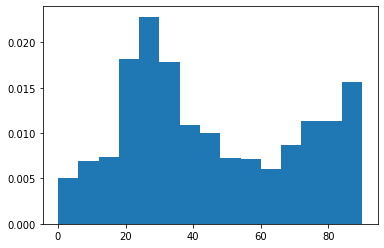

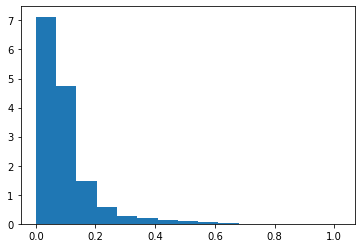

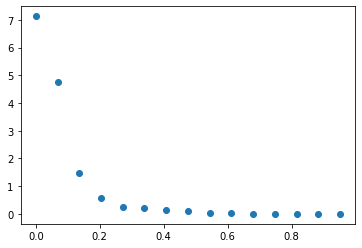

0.09564654702186262
45.356862036354755
<calculating b = 6.6>


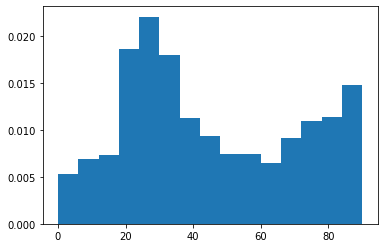

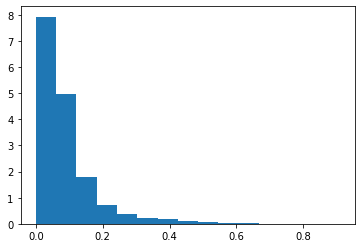

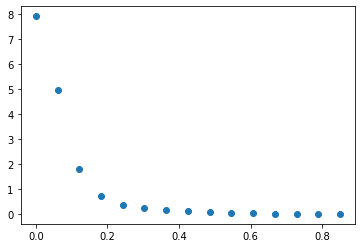

0.09563334613495972
45.11083006016694
<calculating b = 6.7>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal


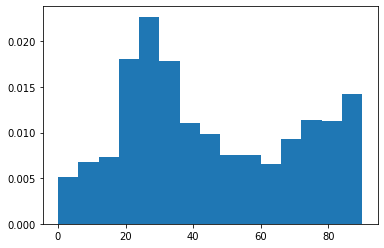

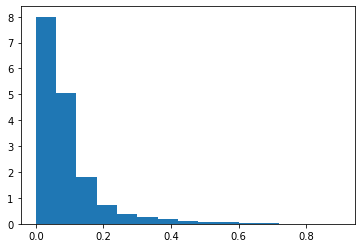

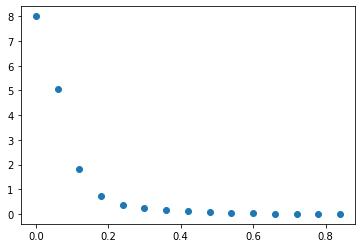

0.09539648400794999
45.178264901274176
<calculating b = 6.8>


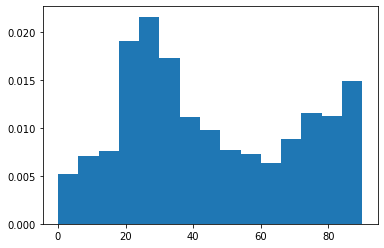

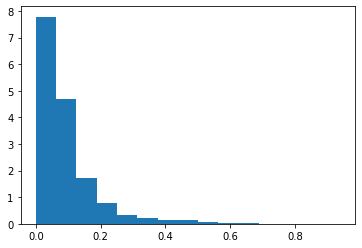

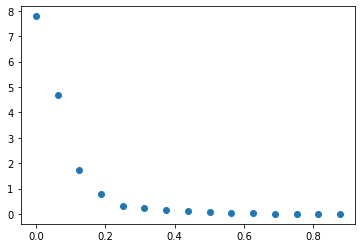

0.09487494256264217
45.14009580100514
<calculating b = 6.9>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in arccos
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


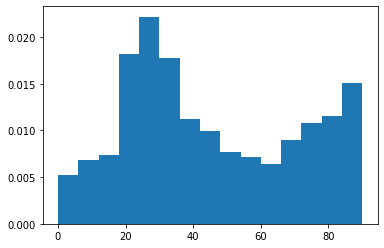

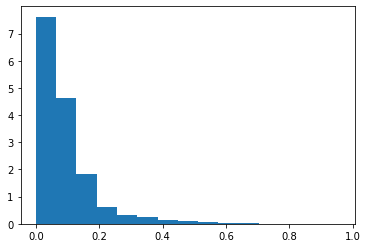

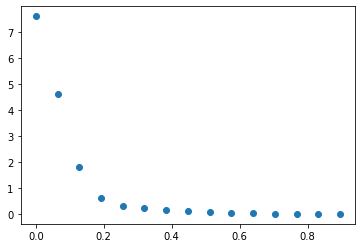

0.09494781584586398
nan
<calculating b = 7.0>


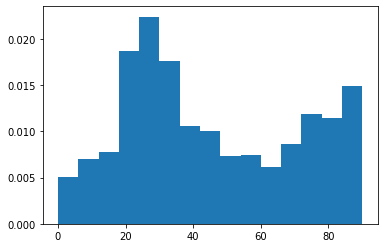

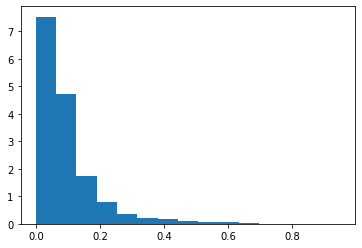

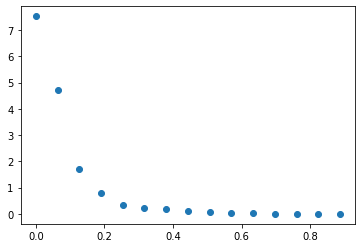

0.09740207854044791
45.205481333111365


In [141]:
col = ["FR","X","Y","ID","speed_nn","ANGLE_int_nn"]
blist = 2 * lin_var[test_var]
v_0_list = []
for T_test in T_test_list[1:2]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    
    v_0_mean = np.empty(blist.shape[0])
    v_0_var = np.empty(blist.shape[0])
    angle_nn_mean = np.empty(blist.shape[0])
    for loc_list_runs in loc_list:
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        v_nn_mean = np.empty(0)
        angle_nn = np.empty(0)
        
        for loc in loc_list_runs:
            if os.path.isfile(loc) == False:
                print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #df['ANGLE_int_nn'] = df['ANGLE_int_nn'].values.astype(np.float) 
            df = df[df['ANGLE_int_nn'].values.astype(np.float) >= 0.0]
            df = df[df['speed_nn'].values.astype(np.float) >= 0.0]
            df = df[df['speed_nn'].values.astype(np.float) < 1.34]

            df = df[df['FR'] > fps * 10]
            df = df[df['Y'] > 0]
            df = df[df['X'] * df['X'] + df['Y']* df['Y'] < 1.]
            v_nn_mean = np.append(v_nn_mean,df['speed_nn'].values.astype(np.float))
            
            #df = df[abs(df['X']) < 0.5]
            #df = df[df['Y'] > 1]

            #df = df[df['Y'] < 1]

            angle_nn = np.append(angle_nn,np.arccos(df['ANGLE_int_nn'].values.astype(np.float))*180./3.1415)

        #plt.hist(v_nn_mean,bins=50)
        #plt.show()
    
        x, bins, p= plt.hist(angle_nn,bins=15,density=True)        
        plt.show()
        
        x, bins, p =plt.hist(v_nn_mean,bins = 15,density=True)
        plt.show()

        nphist = np.histogram(v_nn_mean,bins=15,density = True)
        #plt.plot(nphist[1][:-1],np.log(-np.log(1-nphist[0])), marker = "o", linestyle='none')
        plt.plot(nphist[1][:-1],nphist[0], marker = "o", linestyle='none')
        #plt.xscale("log")
        #plt.yscale("log")
        plt.show()
        #print(v_nn_mean)
        v_0_list.append(v_nn_mean.mean())
        v_0_mean[bi] = v_nn_mean.mean()
        v_0_var[bi] = v_nn_mean.std()
        print(v_nn_mean.mean())
        angle_nn_mean[bi] = angle_nn.mean()
        print(angle_nn.mean())
        bi += 1
        #print(v_nn_mean.mean())


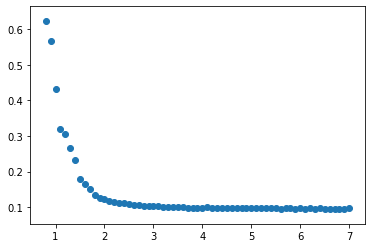

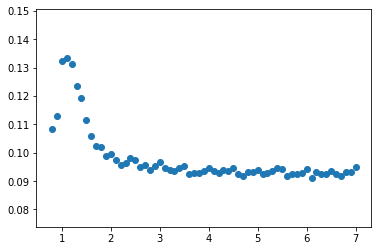

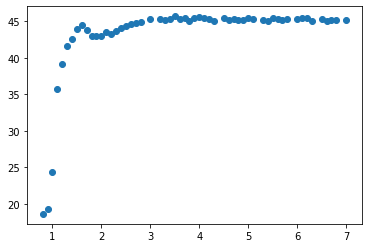

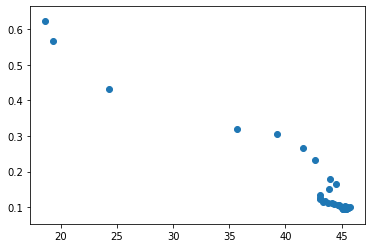

In [143]:
#plt.yscale("exp")
#plt.xscale("log")
plt.scatter(blist,v_0_mean)

plt.show()

plt.scatter(blist,v_0_var)
plt.show()
plt.scatter(blist,angle_nn_mean)
plt.show()

plt.scatter(angle_nn_mean,v_0_mean)

plt.show()


<calculating b = 0.55>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


</calculating b = 0.55>


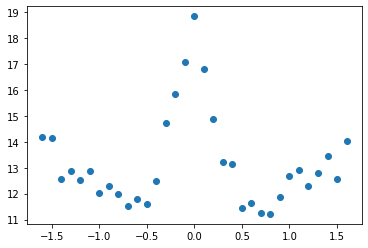

In [45]:
col = ["FR","X","Y","ID"]
t_array = np.arange(t_start, 100 * fps, int(fps/2 ))#
for T_test in T_test_list[0:1]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    ttt_arr = np.empty(0)
    dist_arr = np.empty(0)
    angle_arr = np.empty(0)
    x_ar = np.empty(0)
    y_ar = np.empty(0)
    for loc_list_runs in loc_list[-2:-1]:
        print("<calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")

        for loc in loc_list_runs:
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            min_value = df.groupby('ID')['Y'].min()[df['ID']][0:N_ped - 1]
            #n_max_frame = df.groupby('ID')['FR'].max()[df['ID']][0:N_ped - 1].nlargest(12).index.values
            #print(n_max_frame)
            min_value = min_value[min_value < -0.2]
            key_filtered = min_value.keys().values
            
            df = df[df['ID'].isin(key_filtered)]
            df = df[df['Y'] > 0.]
            df = df[~df['ID'].isin(n_max_frame)]
            
            max_frame = df.groupby('ID')['FR'].max()[df['ID']]
            #print(max_frame.groupby('ID').nlargest(1))
            df['max_frame'] = max_frame.values
            df = df[df['FR'].isin(t_array)]

            #print(max_frame)


            x = df['X'].values
            y = df['Y'].values
            #dist_ttt = np.round(dist(-0.4, 0., 0.4, 0., x, y),2)
            dist_ttt = np.round(np.sqrt( x * x + y * y),1)
            angle_ttt = np.round(np.arctan(y/x),1)
            ttt = df['max_frame'].values - df['FR'].values
            ttt_arr = np.append(ttt_arr,ttt)
            dist_arr = np.append(dist_arr,dist_ttt)
            angle_arr = np.append(angle_arr,angle_ttt)
            x_ar = np.append(x_ar,x)
            y_ar = np.append(y_ar,y)
        print("</calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")
        #print(dist_ttt.shape)
        #print(ttt.shape)
        #print(np.array(ttt_arr))
        df_plot = pd.DataFrame({"ttt" :  ttt_arr  / fps,"angle":angle_arr, "dist": dist_arr,"x":x_ar,"y":y_ar })
        #plt.plot(dist_arr,ttt_arr/fps,marker = "o",linestyle='none')
        #print(df_plot)
        #print(df_plot)
        bi += 1
        df_mean = df_plot[df_plot["dist"] < 1.2]
        df_mean = df_mean[df_mean["dist"] > 1.0]

        df_mean = df_mean.groupby("angle").mean()
        #print(df_mean)
        plt.plot(df_mean.index,df_mean["ttt"],marker = "o",linestyle='none')
        #plt.xscale('log')
        #plt.yscale('log')
        plt.show()
        #plt.plot(df_plot["dist"].values, ttt_mean_list,marker = "o",linestyle='none')
   # plt.show()


In [35]:
"""theta = df_plot['angle'].values
r = df_plot['dist'].values
ttt = df_plot['ttt'].values

x_arr = r * np.cos(theta)
y_arr = r * np.sin(theta)

x, y = np.meshgrid(x_arr, y_arr)
ttt_mesh = np.meshgrid(ttt,ttt)
z = ttt_mesh[:-1, :-1].flatten()

z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=12, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
print(z.mean())
print("corridor width = ", bi)
if bi == 1.7 or bi == 1.2:
    print("density jump")
line_width = 2.5
add_wall(line_width,bi*2)
name_var = lin_var[test_var][test_var_count]
test_var_count += 1"""

'theta = df_plot[\'angle\'].values\nr = df_plot[\'dist\'].values\nttt = df_plot[\'ttt\'].values\n\nx_arr = r * np.cos(theta)\ny_arr = r * np.sin(theta)\n\nx, y = np.meshgrid(x_arr, y_arr)\nttt_mesh = np.meshgrid(ttt,ttt)\nz = ttt_mesh[:-1, :-1].flatten()\n\nz_min, z_max = np.abs(z).min(), np.abs(z).max()\nfig, ax = plt.subplots()\nc = ax.pcolormesh(x, y, z, cmap=\'hot\', vmin=z_min, vmax=12, label="density in [m^-2]")\n# set the limits of the plot to the limits of the data\nax.axis([x.min(), x.max(), y.min(), y.max()])\nfig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")\nprint(z.mean())\nprint("corridor width = ", bi)\nif bi == 1.7 or bi == 1.2:\n    print("density jump")\nline_width = 2.5\nadd_wall(line_width,bi*2)\nname_var = lin_var[test_var][test_var_count]\ntest_var_count += 1'

In [36]:
"""df_plot['x']= np.round(x_arr,1)
df_plot['y']= np.round(y_arr,1)
df_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})"""

'df_plot[\'x\']= np.round(x_arr,1)\ndf_plot[\'y\']= np.round(y_arr,1)\ndf_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})'

In [46]:
x_arr = np.round(np.arange(-3.5,3.5,0.1),1)
y_arr = np.round(np.arange(0,10,0.1),1)


In [56]:
ttt_arr = np.zeros([y_arr.shape[0],x_arr.shape[0]])
df_plot2 = df_plot
df_plot2['x'] = np.round(df_plot2['x'].values,1)
df_plot2['y'] = np.round(df_plot2['y'].values,1)

x_i = 0
for x in x_arr:
    y_i = 0
    for y in y_arr:
        x_bool = df_plot2['x'] == x
        df_new = df_plot2[x_bool]
        y_bool = df_new['y'] == y

        df_new = df_new[y_bool]
        #print(df_new['ttt'].values.shape[0])
        if (df_new['ttt'].values.shape[0]  and x*x + y*y < 4 and x*x + y * y > 0.09):
            ttt_arr[y_i][x_i] += df_new['ttt'].values.sum()/df_new['ttt'].values.shape[0]
            
        y_i += 1
    x_i += 1


In [57]:
print(x_arr.shape,y_arr.shape)
ttt_arr.shape

(70,) (100,)


(100, 70)

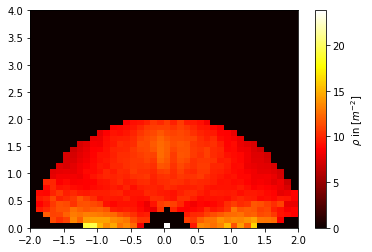

In [58]:
x, y = np.meshgrid(x_arr, y_arr)

r = x * x + y * y


z = np.divide(ttt_arr,r, where= r != 0)

#z = ttt_arr
#z = r
#print(z[z > 0])
z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=z_max, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.xlim([-2,2])
plt.ylim([0,4])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
#print(z.mean())
#print("corridor width = ", bi)
#if bi == 1.7 or bi == 1.2:
#    print("density jump")
#line_width = 2.5
#add_wall(line_width,bi*2)
#name_var = lin_var[test_var][test_var_count]
#test_var_count += 1

In [190]:
np.arccos(np.array([0.1,0.5,0.7,-1]))

array([1.47062891, 1.04719755, 0.79539883, 3.14159265])

In [22]:
if 1 - 1:
    print(1)